In [27]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# Kaggle Rome dataset base line: ResNet50 finetuning
Check for GPU

In [28]:
tf.get_logger().setLevel('ERROR')
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [29]:
data_dir = "./../data/kaggle-rome-weather-dataset-resized"
batch_size = 16
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [30]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   preprocessing_function=keras.applications.resnet50.preprocess_input,
                                   validation_split= 0.2,
                                   cval=0)

Get training data

In [31]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='training', seed=seed,
                                                    class_mode='categorical')
img_train

Found 200 images belonging to 5 classes.


Get test data

In [32]:
img_test = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='validation', seed=seed,
                                                    class_mode='categorical')
img_test

Found 50 images belonging to 5 classes.


Load ResNet50

(approach taken from: https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b)

In [33]:
input_tensor = keras.Input(shape=(image_height,image_width,nr_color_channels))
resnet50_model = keras.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=input_tensor)

Freeze layers apart from last block 

In [34]:
for layer in resnet50_model.layers[:134]:
    layer.trainable = False

Add new layers

In [35]:
model = keras.models.Sequential()
model.add(resnet50_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(5,activation='softmax'))

Create model checkpoints

In [36]:
filepath = "./" + 'models/rome_resnet_extended/rome_resnet_extended_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [37]:
callbacks_list = [check_point]

In [38]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [39]:
history = model.fit(img_train,
                    steps_per_epoch=(len(img_train.filenames) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
12/12 [==============================] - 12s 278ms/step - loss: 2.2242 - accuracy: 0.2391 - val_loss: 1.7130 - val_accuracy: 0.1875

Epoch 00001: val_accuracy improved from -inf to 0.18750, saving model to ./models/rome_resnet_extended\rome_resnet_extended_01-0.1875.hdf5


c:\Users\selin\miniconda3\envs\cov-project\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/25
12/12 [==============================] - 4s 326ms/step - loss: 2.2006 - accuracy: 0.2500 - val_loss: 1.7313 - val_accuracy: 0.1875

Epoch 00002: val_accuracy did not improve from 0.18750
Epoch 3/25
12/12 [==============================] - 4s 321ms/step - loss: 2.0792 - accuracy: 0.2880 - val_loss: 1.6602 - val_accuracy: 0.1250

Epoch 00003: val_accuracy did not improve from 0.18750
Epoch 4/25
12/12 [==============================] - 4s 352ms/step - loss: 2.0626 - accuracy: 0.2065 - val_loss: 1.6654 - val_accuracy: 0.1667

Epoch 00004: val_accuracy did not improve from 0.18750
Epoch 5/25
12/12 [==============================] - 3s 258ms/step - loss: 2.2426 - accuracy: 0.2337 - val_loss: 1.6434 - val_accuracy: 0.2292

Epoch 00005: val_accuracy improved from 0.18750 to 0.22917, saving model to ./models/rome_resnet_extended\rome_resnet_extended_05-0.2292.hdf5
Epoch 6/25
12/12 [==============================] - 3s 199ms/step - loss: 1.9881 - accuracy: 0.2446 - val_loss: 1.6658 - 

Evaluate model

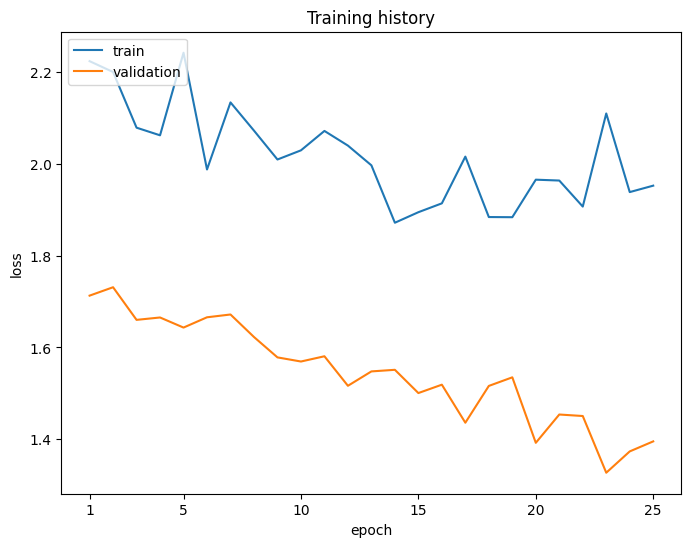

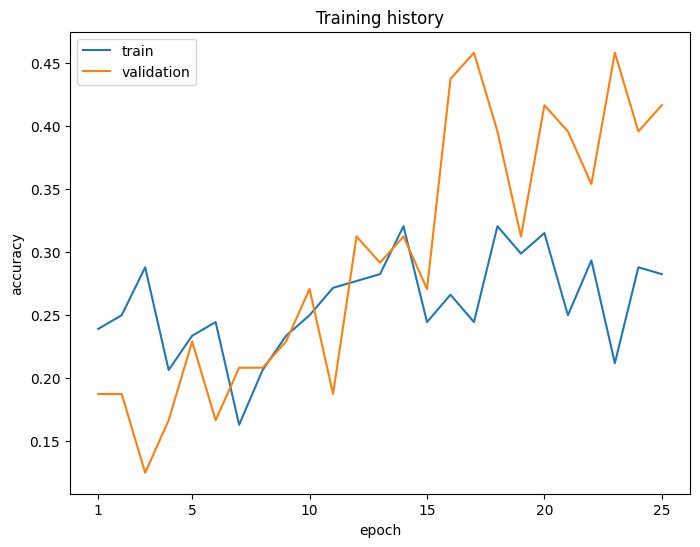

In [40]:
plot_history(history)

In [42]:
model = keras.models.load_model("./models/rome_resnet_extended/rome_resnet_extended_17-0.4583.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

In [43]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[3 4 1 0 2]
 [4 5 0 1 0]
 [3 6 0 0 1]
 [4 5 0 0 1]
 [3 5 1 0 1]]


Class foggy:
    Sensitivity (TPR):  30.000% (3 of 10)
    Specificity (TNR):  65.000% (26 of 40)
    Precision:          17.647% (3 of 17)
    Neg. pred. value:   78.788% (26 of 33)
Class cloudy:
    Sensitivity (TPR):  50.000% (5 of 10)
    Specificity (TNR):  50.000% (20 of 40)
    Precision:          20.000% (5 of 25)
    Neg. pred. value:   80.000% (20 of 25)
Class sunny:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR):  95.000% (38 of 40)
    Precision:           0.000% (0 of 2)
    Neg. pred. value:   79.167% (38 of 48)
Class snowy:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR):  97.500% (39 of 40)
    Precision:           0.000% (0 of 1)
    Neg. pred. value:   79.592% (39 of 49)
Class rainy:
    Sensitivity (TPR):  10.000% (1 of 10)
    Specificity (TNR):  90.000% (36 of 40)
    Precision:          20.000% (1 of 5)
    Neg. pred. value:   80.000% (36 of 45)

Overall accuracy: 

array([[3, 4, 1, 0, 2],
       [4, 5, 0, 1, 0],
       [3, 6, 0, 0, 1],
       [4, 5, 0, 0, 1],
       [3, 5, 1, 0, 1]], dtype=int64)